# Causal Graph Learners

Causal discovery attracts more and more attention recently to infer causal structure from data and disentangle the complex relationship among variables. In the following, we detail a few state-of-the-art causal discovery learners. 

## Overview:

### 1. Causal Graph Terminology and Goal

Consider a graph $\mathcal{G} =(Z,E)$ with a node/variable set $Z$ and an edge set $E$. A node $Z_i$ is said to be a parent of $Z_j$ if there is a directed edge from $Z_i$ to $Z_j$. Let the set of all parents of node $Z_j$ in $\mathcal{G}$ as $PA_{Z_j} (\mathcal{G})$. A directed graph that does not contain directed cycles is called a directed acyclic graph (DAG). Suppose a DAG $\mathcal{G}=(Z,E)$ that characterizes the causal relationship among $|Z|=d$ nodes, where $Z=[Z_1,Z_2,\cdots,Z_d]^\top $ represents a random vector and an edge $Z_i\rightarrow Z_j$ means that $Z_i$ is a direct cause of $Z_j$. Given realizations of the variable set $Z$ as $\{z_1^{(i)},z_2^{(i)},\cdots,z_d^{(i)}\}_{1\leq i \leq n}$, we aim to estimate the underlying causal graph $\mathcal{G}$.

### 2. Causal Graphical Models

#### Model 1: Additive Noise Model

Suppose there exists a weighted DAG $\mathcal{G}=(Z,E)$ that characterizes the causal relationship among $|Z|=d$ nodes. Each variable $Z_i$ is associated with a node $i$ in the DAG $\mathcal{G}$, and the observed value of $Z_i$ is obtained as a function of its parents in the graph plus an independent additive noise $n_i$, i.e., 
\begin{equation}\label{anm}
Z_i := f_i\{PA_{Z_i} (\mathcal{G})\} + n_i,i = 1,2,...,d, 
\end{equation}
where $PA_{Z_i} (\mathcal{G})$ denotes the set of parent variables of $Z_i$ so that there is an edge from $Z_j\in PA_{Z_i} (\mathcal{G})$ to $Z_i$ in the graph, and the noises $n_i$ are assumed to be jointly independent.

#### Model 2: Linear Structural Equation Model

Let $B=\{b_{i,j}\}_{1\leq i\leq d,1\leq j\leq d}$ be a $d\times d$ matrix, where $b_{i,j}$ is the weight of the edge $Z_i\rightarrow Z_j \in E$, and $b_{i,j}=0$ otherwise. Then, we say that $\mathcal{G} =(Z,B)$ is a weighted DAG with the node set $Z$ and the weighted adjacency matrix $B$ (the edge set $E$ is nested in $B$). Under no unmeasured confounders, the Markov condition, the faithfulness condition, causal sufficiency assumption, and the linear structural equation model (LSEM) such that $Z$ characterized by the pair ($\mathcal{G}$, $\epsilon$) is generated by 
\begin{equation}\label{lsem_x}
Z=B^\top Z +\epsilon,
\end{equation}
where $\epsilon $ is a  random vector of jointly independent error variables.


### 3. Overview of Popular Causal Discovery Learners 

Causal discovery learners propose to learn a plusible causal graph from the observational data (up to Markovian Equivalent Class). Wide literature on causal discovery can be summarized in three classes (for both models 1 and 2). 

- The first type focuses on local **conditional independence tests** to find a causal skeleton and then determine the orientation of edges, such as the well-known PC algorithm (Spirtes et al., 2000; Kalisch & Bühlmann, 2007). However, testing the conditional independence of continuous variables is not easy (Shah & Peters, 2018). 

- The second class specifies properly **functional causal models with additional assumptions on data distribution**, including the ICA-LiNGAM (Shimizu et al., 2006) and the causal additive model (CAM) (Bühlmann et al., 2014). 

- The last class, **the score-based method**, includes the greedy equivalence search (GES) (Chickering, 2002) and the fast GES (fGES) (Ramsey et al., 2017) that use for example Bayesian scores in searching a space of causal models. Recently, Zheng et al. (2018) opened up another track of score-based methods by constructing an optimization with an acyclicity constraint under the linear structural equation model (LSEM), i.e. the NOTEARS. A follow-up work using a VAE parameterized by a graph neural network that generalizes LSEM was proposed in Yu et al. (2019) with a more computational friendly constraint, namely DAG-GNN. Also see Zhu & Chen (2019) and Cai et al. (2021) for other cutting-edge structural learning methods. 



| Learners |    Type    | Supported Model  | Noise Distribution | Handle High-Dimensional? |
|----------|------------|------------------|--------------------|--------------------------|
|    PC    | Testing    |   Model 1 & 2    |       Normal       |       Need Sparsity      |
|ICA-LiNGAM| Functional |     Model 1      |    Pre-specified   |       Need Sparsity      |
| NOTEARS  |    Score   |     Model 2      |       Arbitriry    |            Yes           |
|  DAGGNN  |    Score   |     Model 2      |       Arbitriry    |            Yes           |

## Generate Synthetic Datasets

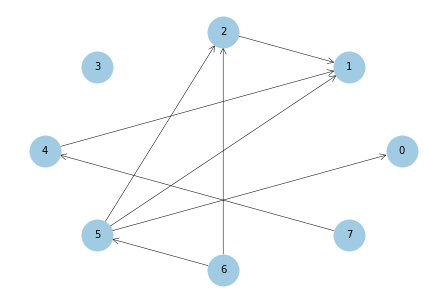

In [1]:
import os
import numpy as np
from utils import *
from synthetic_datasets import *
seed = 1234
np.random.seed(seed)
d = 8
n = 300
ground_truth_G = simulate_random_dag(d=d, degree=2, graph_type='erdos-renyi', w_range = (1.0, 1.0))
c = np.zeros(d)
s = np.ones([d])
df = simulate_lsem(G = ground_truth_G, A_type ='Gaussian', n = n, baseline=0).reshape((n,d))

#plot true causal graph:
plot_net(nx.to_numpy_array(ground_truth_G), labels_name=list(range(d))) 

#### Summary of Results under Different Causal Graph Learners.

Note: The estimated graphs (after pruning) are evaluated by three metrics: the false discovery rate (FDR), the true positive rate (TPR), and the structural Hamming distance (SHD, the smallest number of edge additions, deletions, and reversals to convert the estimated graph into the true DAG). Here, the SHD takes into account both false positives and negatives and a lower SHD indicates a better estimate of the causal graph.

| Learners |   FDR   |   TPR   |   SHD   |
|----------|---------|---------|---------|
|    PC    |   0.00  |   0.50  |   4     |
|ICA-LiNGAM|   0.67  |   0.25  |   7     |
| NOTEARS  |   0.00  |   0.62  |   3     |
|  DAGGNN  |   0.00  |   0.62  |   3     |

## PC Learner (Spirtes et al., 2000)

The classical PC algorithm (Spirtes et al., 2000) proposes to leverage the Fisher-z test for conditional independence testing, in order to determine the orientation/direction of the edge between each pair of the nodes. The implementation is available through the py-causal package at https://github.com/bd2kccd/py-causal, written in highly optimized Java codes. Also see examples here https://github.com/bd2kccd/py-causal/blob/development/example/py-causal%20-%20PC-ALL%20in%20Action.ipynb.
 

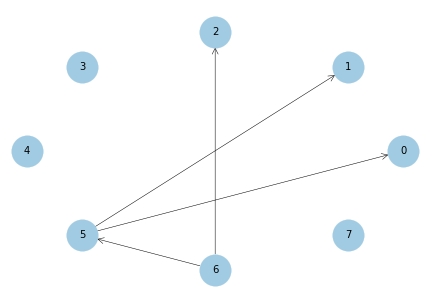

FDR: 0.0
TPR: 0.5
SHD: 4


In [2]:
# ! pip install pydot 
# ! pip install git+https://github.com/bd2kccd/py-causal
from utils import *
import pydot
from pycausal.pycausal import pycausal as pc
from pycausal import search as s
pc = pc()
pc.start_vm() 
tetrad = s.tetradrunner() 
new_df = pd.DataFrame(data=df, index=range(len(df)), columns=map('{:02}'.format, range(d)))
tetrad.run(algoId = 'pc-all', dfs = new_df, testId = 'fisher-z-test')
graph = tetrad.getTetradGraph()
nodes = graph.getNodes()
dot_str = pc.tetradGraphToDot(graph)
graphs = pydot.graph_from_dot_data(dot_str)
for node in map('{:02}'.format, range(d)):
    node_a = pydot.Node(node, style="filled", fillcolor="red")
    graphs[0].add_node(node_a)
graph = nx.to_numpy_array(nx.nx_pydot.from_pydot(graphs[0]))
pc_res = np.matrix(graph)
pc_res[np.abs(pc_res) < 0.3] = 0 
#plot the estimated causal graph:
plot_net(pc_res, labels_name=list(range(d))) 

FDR, TPR, SHD = count_accuracy(nx.DiGraph(ground_truth_G), nx.DiGraph(pc_res))
print('FDR:', np.round(FDR, 2)) 
print('TPR:', np.round(TPR, 2)) 
print('SHD:', np.round(SHD, 2)) 

## ICA-LiNGAM Learner (Shimizu et al., 2006)

The ICA-LiNGAM (Shimizu et al., 2006) algorithm assumes linear non-Gaussian additive model (Model 1 above) to recover the weighted adjacency matrix. The ICA-LiNGAM is implemented with default hyper-parameters through the lingam package for all settings. See their repository at https://github.com/cdt15/lingam.

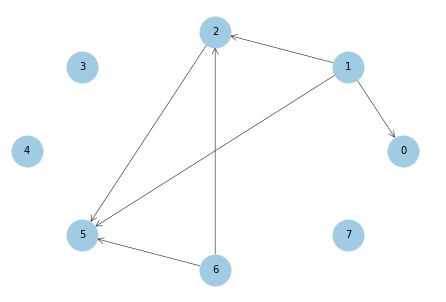

FDR: 0.67
TPR: 0.25
SHD: 7


In [3]:
# ! pip install igraph
# ! pip install lingam
# ! pip install factor_analyzer
import lingam
from utils import *
model = lingam.DirectLiNGAM()
model.fit(df.reshape(len(df),d)) 
graph = model.adjacency_matrix_
ica_res = np.matrix(graph).T
ica_res[np.abs(ica_res) < 0.3] = 0 
#plot the estimated causal graph:
plot_net(ica_res, labels_name=list(range(d))) 

FDR, TPR, SHD = count_accuracy(nx.DiGraph(ground_truth_G), nx.DiGraph(ica_res))
print('FDR:', np.round(FDR, 2)) 
print('TPR:', np.round(TPR, 2)) 
print('SHD:', np.round(SHD, 2)) 

## NOTEARS Learner (Zheng et al., 2018)

The NOTEARS learner (Zheng et al., 2018) estimates the weighted adjacency matrix by formulating the optimization with an acyclicity constraint. The implementation is available at their repository at https://github.com/xunzheng/notears. 

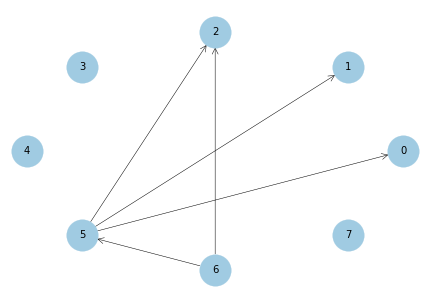

FDR: 0.0
TPR: 0.62
SHD: 3


In [4]:
from utils import *
from notears import *
graph = notears_linear(df.reshape(len(df),d), lambda1=0.1, loss_type='l2')
notears_res = np.matrix(graph)
notears_res[np.abs(notears_res) < 0.3] = 0 
#plot the estimated causal graph:
plot_net(notears_res, labels_name=list(range(d))) 

FDR, TPR, SHD = count_accuracy(nx.DiGraph(ground_truth_G), nx.DiGraph(notears_res))
print('FDR:', np.round(FDR, 2)) 
print('TPR:', np.round(TPR, 2)) 
print('SHD:', np.round(SHD, 2)) 

## DAG-GNN Learner (Yu et al., 2019) and ANOCE-CVAE Learner (Cai et al., 2020)

The DAG-GNN learner (Yu et al., 2019) incorporates the variational auto-encoder into causal discovery with a modified smooth characterization on acyclicity in the evidence lower bound as the loss function. Codes are available at their repository at https://github.com/ fishmoon1234/DAG-GNN based on PyTorch (Paszke et al., 2017). 

The ANOCE-CVAE learner (Cai et al., 2020) is constrained causal structure learning method by incorporating a novel identification constraint that specifies the temporal causal relationship of variables. The code is publicly available at an anonymous repository at https://github.com/anoce-cvae/ANOCE-CVAE.

In [5]:
import pickle
with open('demo_data.pkl', 'wb') as f:
    pickle.dump(np.reshape(np.array(df), (len(df),d,1)),f)

In [6]:
%run train.py --data_type='realdata' --real_data_file='demo_data.pkl' --node_number=8 --sample_size=300 --batch_size=100 --rep_number=1


Namespace(A_type='Binary', batch_size=100, data_type='realdata', epochs=200, graph_degree=2, k_max_iter=100.0, node_number=8, original_lr=0.003, real_data_file='demo_data.pkl', rep_number=1, sample_size=300, seed=2333, simu_G_file='s1_trueG.pkl')


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


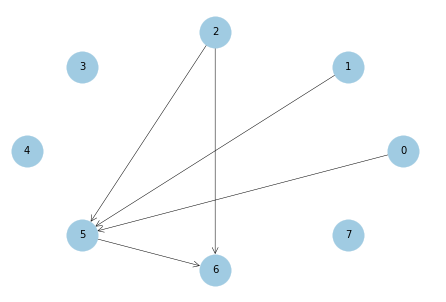

FDR: 0.0
TPR: 0.62
SHD: 3


In [7]:
with open(os.path.join('ANOCE_Results.data'), 'rb') as data:
    anoce_res = pickle.load(data)[0]
anoce_res[np.abs(anoce_res) < 0.3] = 0 
#plot the estimated causal graph:
plot_net(anoce_res.T, labels_name=list(range(d)))  
FDR, TPR, SHD = count_accuracy(nx.DiGraph(ground_truth_G), nx.DiGraph(anoce_res))
print('FDR:', np.round(FDR, 2)) 
print('TPR:', np.round(TPR, 2)) 
print('SHD:', np.round(SHD, 2)) 

## References

[1] Judea Pearl et al. Causal inference in statistics: An overview. Statistics surveys, 3:96–146, 2009.

[2] Pater Spirtes, Clark Glymour, Richard Scheines, Stuart Kauffman, Valerio Aimale, and Frank Wimberly. Constructing bayesian network models of gene expression networks from microarray data. 2000.

[3] Markus Kalisch and Peter Bühlmann. Estimating high-dimensional directed acyclic graphs with the pc-algorithm. Journal of Machine Learning Research, 8(Mar):613–636, 2007.

[4] Rajen D Shah and Jonas Peters. The hardness of conditional independence testing and the generalised covariance measure. arXiv preprint arXiv:1804.07203, 2018.

[5] Shohei Shimizu, Patrik O Hoyer, Aapo Hyvärinen, and Antti Kerminen. A linear non-gaussian acyclic model for causal discovery. Journal of Machine Learning Research, 7(Oct):2003–2030, 2006.

[6] Peter Bühlmann, Jonas Peters, Jan Ernest, et al. Cam: Causal additive models, high-dimensional order search and penalized regression. The Annals of Statistics, 42(6):2526–2556, 2014.

[7] David Maxwell Chickering. Optimal structure identification with greedy search. Journal of machine learning research, 3(Nov):507–554, 2002.

[8] Joseph Ramsey, Madelyn Glymour, Ruben Sanchez-Romero, and Clark Glymour. A million variables and more: the fast greedy equivalence search algorithm for learning high-dimensional graphical causal models, with an application to functional magnetic resonance images. International journal of data science and analytics, 3(2):121–129, 2017.

[9] Xun Zheng, Bryon Aragam, Pradeep K Ravikumar, and Eric P Xing. Dags with no tears: Continuous optimization for structure learning. In Advances in Neural Information Processing Systems, pp. 9472–9483, 2018.

[10] Yue Yu, Jie Chen, Tian Gao, and Mo Yu. Dag-gnn: Dag structure learning with graph neural networks.
arXiv preprint arXiv:1904.10098, 2019.

[11] Shengyu Zhu and Zhitang Chen. Causal discovery with reinforcement learning. arXiv preprint arXiv:1906.04477, 2019.

[12] Cai, Hengrui, Rui Song, and Wenbin Lu. "ANOCE: Analysis of Causal Effects with Multiple Mediators via Constrained Structural Learning." International Conference on Learning Representations. 2020.